# Run the speciation model with fastscape

In [1]:
import numpy as np
import pandas as pd
import xsimlab as xs
import matplotlib.pyplot as plt

from fastscape.models import basic_model
from fastscape.processes import MultipleFlowRouter

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from paraspec.fastscape_ext import IR12Speciation, EnvironmentElevation

## Speciation without competition in an evolving landscape

In [2]:
model = basic_model.update_processes({
    'life_env': EnvironmentElevation,
    'life': IR12Speciation,
    'flow': MultipleFlowRouter
})

model

<xsimlab.Model (18 processes, 24 inputs)>
grid
    shape               [in] ('shape_yx',) nb. of grid nodes in (y, x)
    length              [in] ('shape_yx',) total grid length in (y, x)
boundary
    status              [in] () or ('border',) node status at borders
fs_context
uplift
    rate                [in] () or ('y', 'x') uplift rate
tectonics
init_topography
    seed                [in] random seed
surf2erode
init_erosion
diffusion
    diffusivity         [in] () or ('y', 'x') diffusivity (transpor...
flow
    slope_exp           [in] () or ('y', 'x') MFD partioner slope e...
drainage
spl
    k_coef              [in] () or ('y', 'x') bedrock channel incis...
    area_exp            [in] drainage area exponent
    slope_exp           [in] slope exponent
erosion
vmotion
topography
terrain
life_env
life
    init_size           [in] initial population size
    init_min_trait      [in] initial min trait value
    init_max_trait      [in] initial max trait value
    min_env         

In [3]:
in_ds = xs.create_setup(
    model=model,
    clocks={
        'time': np.linspace(0., 1e6, 1001),
        'out': np.linspace(0., 1e6, 101)
    },
    master_clock='time',
    input_vars={
        'grid__shape': [201, 201],
        'grid__length': [2e4, 2e4],
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': 1e-3,
        'flow__slope_exp': 1.,
        'spl__k_coef': 1e-4,
        'diffusion__diffusivity': 1e-3,
        'life': {
            'init_size': 100,
            'init_min_trait': 0.5, #0,
            'init_max_trait': 0.5, #100,
            'min_env': 0,
            'max_env': 400,
            'nb_radius': 2e3,
            'car_cap': 25,
            'sigma_mov': 100.,
            'mut_prob': 0.05,
            'sigma_mut': 0.05, #25,
            'sigma_w': 0.2, #50,
            'random_seed': 1234,
            'rescale_rates':True
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'drainage__area': 'out',
        'life__x': 'out',
        'life__y': 'out',
        'life__opt_trait': 'out',
        'life__trait': 'out',
        'life__parent': 'out',
        'life__id': 'out'
    }
)

In [4]:
with xs.monitoring.ProgressBar():
    out_ds = in_ds.xsimlab.run(model=model)

             0% | initialize 

In [5]:
df = (
    out_ds
    # only keep paraspec output variables
    .drop_dims([d for d in out_ds.dims if d not in ('out', 'pop')])
    .drop_vars(in_ds, errors='ignore')
    # convert to a dataframe
    # see https://xarray-simlab.readthedocs.io/en/latest/io_storage.html#dynamically-sized-arrays
    .stack(fpop=('out', 'pop'))
    .dropna('fpop', how='all')
    .to_dataframe()
    # clean
    .rename(columns=lambda name: name.replace('life__', ''))
    .reset_index()
    .dropna()
    .set_index('id', drop=False)
    # assign tree-specific extra columns
    #.assign(
    #    tree_id=lambda df: df.ptree.tree_id,
    #    node_type=lambda df: df.ptree.node_type
    #)
)


df

,out,pop,id,opt_trait,parent,trait,x,y
id,,,,,,,,
1.0,0.0,1,1.0,0.026448,1.0,0.500000,7603.914700,12383.220327
2.0,0.0,2,2.0,0.025842,2.0,0.500000,18464.924675,6035.148592
3.0,0.0,3,3.0,0.025261,3.0,0.500000,5233.848477,3496.929023
4.0,0.0,4,4.0,0.025405,4.0,0.500000,6381.941168,9910.103904
5.0,0.0,5,5.0,0.026521,5.0,0.500000,2361.824659,15211.408005
...,...,...,...,...,...,...,...,...
798851.0,990000.0,869,798851.0,0.502174,797977.0,0.371060,65.868239,7135.566493
798852.0,990000.0,870,798852.0,0.461287,797978.0,0.440795,527.266373,6759.766995
798853.0,990000.0,871,798853.0,0.393790,797979.0,0.301238,84.640059,6152.447808


## Plot population

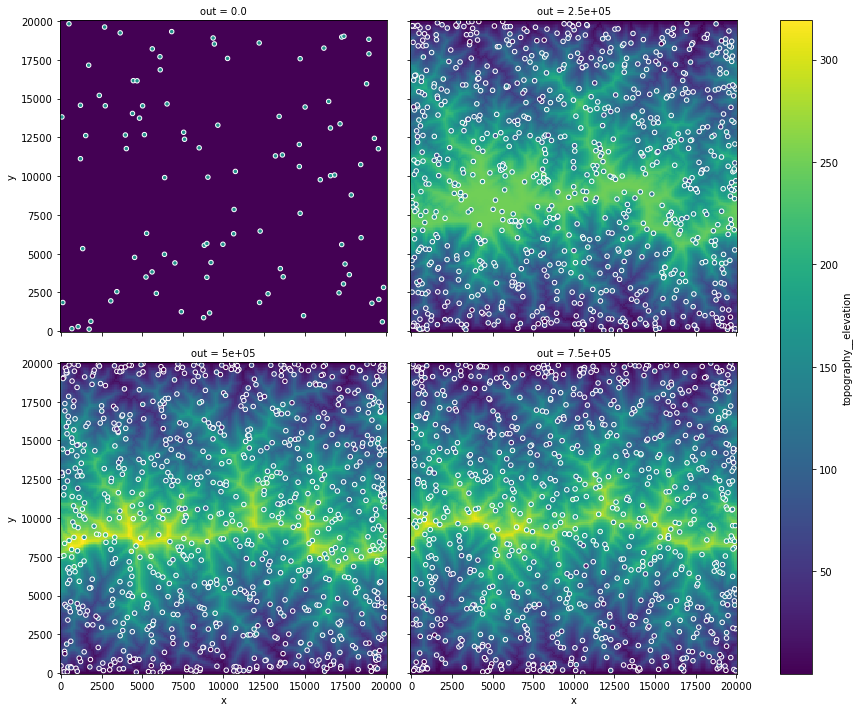

In [6]:
times = np.arange(0, 1e6, 2.5e5)
elev_max = out_ds.topography__elevation.max()


fg = (out_ds
      .sel(out=times)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10)))


for ax, t in zip(fg.axes.ravel(), times):
    pop = df[df.out==t]
    ax.scatter(pop.x, pop.y, c=pop.trait, vmin=0, vmax=1, s=20, edgecolor='w')

Text(0.5, 0, 'Time(years)')

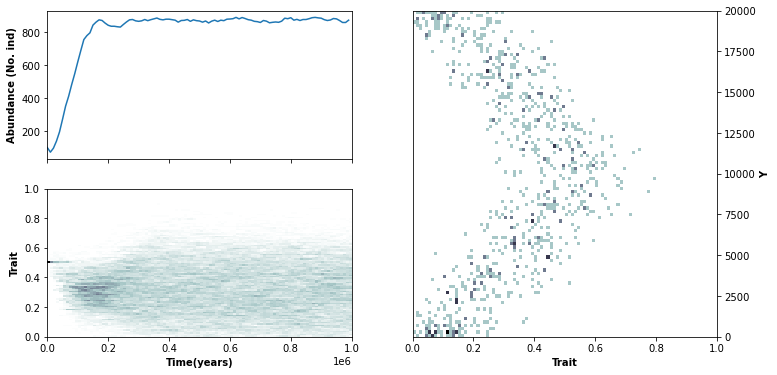

In [7]:
fig2, axs2 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
gs2 = axs2[1, 1].get_gridspec()
for ax in axs2[0:, -1]:
    ax.remove()
axbig = fig2.add_subplot(gs2[0:, -1])
axs2[0,0].plot(df.groupby('out').size())
h,xedge,yedge,_=axs2[1,0].hist2d(x=df['out'], y=df['trait'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axbig.hist2d(x=df['trait'].loc[df['out']==max(df['out'])], 
                             y=df['y'].loc[df['out']==max(df['out'])], 
                                 range=((0, 1), (0, 20000)), 
                                 bins=(100, 100), cmap='bone_r')
axbig.yaxis.set_label_position("right")
axbig.yaxis.tick_right()
axbig.set_ylabel('Y', weight='bold')
axbig.set_xlabel('Trait', weight='bold')
axs2[0,0].set_ylabel('Abundance (No. ind)', weight='bold')
axs2[1,0].set_ylabel('Trait', weight='bold')
axs2[1,0].set_xlabel('Time(years)', weight='bold')

## Speciation with competition in an evolving landscape

In [8]:
from paraspec.fastscape_ext import DD03Speciation

In [9]:
model2 = basic_model.update_processes({
    'life_env': EnvironmentElevation,
    'life': DD03Speciation,
    'flow': MultipleFlowRouter
})
model2

<xsimlab.Model (18 processes, 27 inputs)>
grid
    shape                [in] ('shape_yx',) nb. of grid nodes in (y...
    length               [in] ('shape_yx',) total grid length in (y...
boundary
    status               [in] () or ('border',) node status at borders
fs_context
uplift
    rate                 [in] () or ('y', 'x') uplift rate
tectonics
init_topography
    seed                 [in] random seed
surf2erode
init_erosion
diffusion
    diffusivity          [in] () or ('y', 'x') diffusivity (transpo...
flow
    slope_exp            [in] () or ('y', 'x') MFD partioner slope ...
drainage
spl
    k_coef               [in] () or ('y', 'x') bedrock channel inci...
    area_exp             [in] drainage area exponent
    slope_exp            [in] slope exponent
erosion
vmotion
topography
terrain
life_env
life
    init_size            [in] initial population size
    init_min_trait       [in] initial min trait value
    init_max_trait       [in] initial max trait value
    min_env 

In [10]:
in_ds2 = xs.create_setup(
    model=model2,
    clocks={
        'time': np.linspace(0., 1e6, 1001),
        'out': np.linspace(0., 1e6, 101)
    },
    master_clock='time',
    input_vars={
        'grid__shape': [201, 201],
        'grid__length': [2e4, 2e4],
        'boundary__status': ['looped', 'looped', 'fixed_value', 'fixed_value'],
        'uplift__rate': 1e-3,
        'flow__slope_exp': 1.,
        'spl__k_coef': 1e-4,
        'diffusion__diffusivity': 1e-3,
        'life': {
            'init_size': 100,
            'init_min_trait': 0.5,
            'init_max_trait': 0.5,
            'min_env': 0,
            'max_env': 400,
            'birth_rate': 1.,
            'movement_rate': 5.,
            'car_cap_max': 1000.,
            'sigma_opt_trait': 0.2,
            'mut_prob': 0.05,
            'sigma_mut': 0.05,
            'sigma_mov': 100.,
            'sigma_comp_trait': 0.9,
            'sigma_comp_dist': 0.2,
            'random_seed': 1234,
            'rescale_rates':True
        }
    },
    output_vars={
        'topography__elevation': 'out',
        'drainage__area': 'out',
        'life__x': 'out',
        'life__y': 'out',
        'life__trait': 'out',
        'life__parent': 'out',
        'life__id': 'out'
    }
)

In [11]:
with xs.monitoring.ProgressBar():
    out_ds2 = in_ds2.xsimlab.run(model=model2)

             0% | initialize 

In [12]:
df2 = (
    out_ds2
    # only keep paraspec output variables
    .drop_dims([d for d in out_ds2.dims if d not in ('out', 'pop')])
    .drop_vars(in_ds2, errors='ignore')
    # convert to a dataframe
    # see https://xarray-simlab.readthedocs.io/en/latest/io_storage.html#dynamically-sized-arrays
    .stack(fpop=('out', 'pop'))
    .dropna('fpop', how='all')
    .to_dataframe()
    # clean
    .rename(columns=lambda name: name.replace('life__', ''))
    .reset_index()
    .dropna()
    .set_index('id', drop=False)
    # assign tree-specific extra columns
    #.assign(
    #    tree_id=lambda df: df.ptree.tree_id,
    #    node_type=lambda df: df.ptree.node_type
    #)
)


df2

,out,pop,id,parent,trait,x,y
id,,,,,,,
112.0,0.0,1,112.0,1.0,0.500000,7539.461251,12491.346416
113.0,0.0,2,113.0,2.0,0.500000,18495.890439,6305.806635
114.0,0.0,3,114.0,3.0,0.500000,5122.075909,3412.820993
115.0,0.0,4,115.0,7.0,0.500000,6265.798751,5114.602983
116.0,0.0,5,116.0,8.0,0.500000,19254.740571,12363.358516
...,...,...,...,...,...,...,...
1576577.0,1000000.0,1740,1576577.0,1574553.0,0.236160,19008.565457,18899.416024
1576578.0,1000000.0,1741,1576578.0,1574564.0,0.075985,8885.764917,361.744133
1576579.0,1000000.0,1742,1576579.0,1574572.0,0.165152,19630.860542,19436.492127


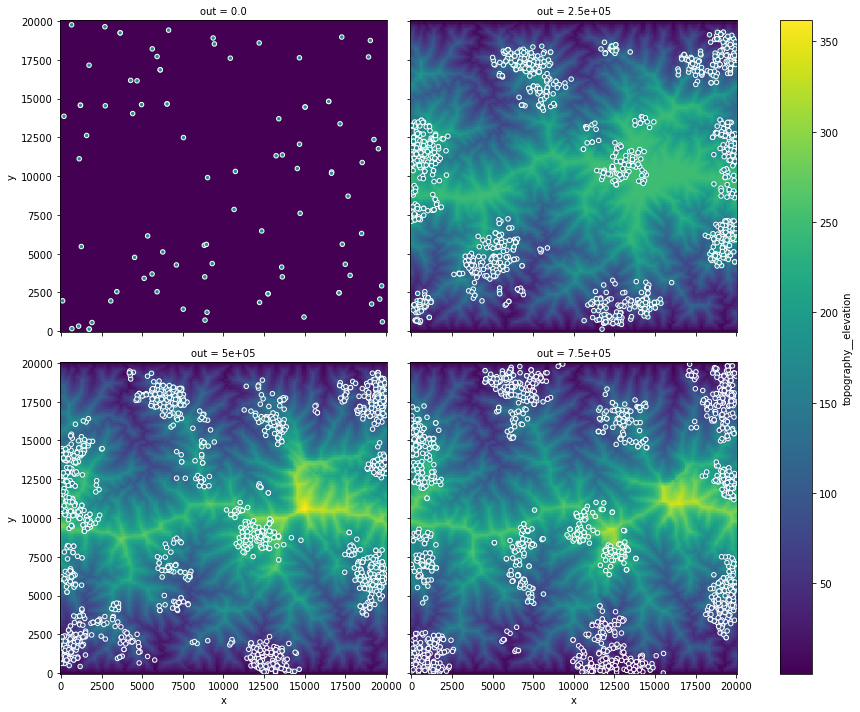

In [13]:
times = np.arange(0, 1e6, 2.5e5)
elev_max = out_ds2.topography__elevation.max()


fg = (out_ds2
      .sel(out=times)
      .topography__elevation.plot(col='out', col_wrap=2, figsize=(13, 10)))


for ax, t in zip(fg.axes.ravel(), times):
    pop = df2[df2.out==t]
    ax.scatter(pop.x, pop.y, c=pop.trait, vmin=0, vmax=1, s=20, edgecolor='w')

Text(0.5, 0, 'Time(years)')

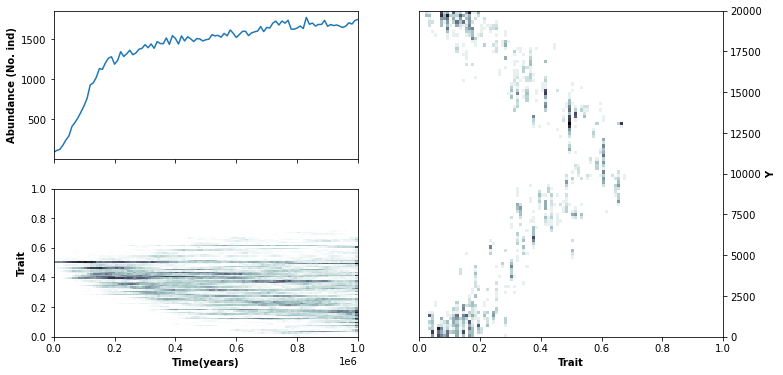

In [14]:
fig5, axs5 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
gs5 = axs5[1, 1].get_gridspec()
for ax in axs5[0:, -1]:
    ax.remove()
axbig = fig5.add_subplot(gs5[0:, -1])
axs5[0,0].plot(df2.groupby('out').size())
h,xedge,yedge,_=axs5[1,0].hist2d(x=df2['out'], y=df2['trait'], 
                                 range=((0, 1e6), (0, 1)), 
                                 bins=(100, 100), cmap='bone_r')
h,xedge,yedge,_=axbig.hist2d(x=df2['trait'].loc[df2['out']==max(df2['out'])], 
                             y=df2['y'].loc[df2['out']==max(df2['out'])], 
                                 range=((0, 1), (0, 20000)), 
                                 bins=(100, 100), cmap='bone_r')
axbig.yaxis.set_label_position("right")
axbig.yaxis.tick_right()
axbig.set_ylabel('Y', weight='bold')
axbig.set_xlabel('Trait', weight='bold')
axs5[0,0].set_ylabel('Abundance (No. ind)', weight='bold')
axs5[1,0].set_ylabel('Trait', weight='bold')
axs5[1,0].set_xlabel('Time(years)', weight='bold')